In this project, we will use a Convolutional Neural Network (CNN) to build, train, and test a traffic sign classification model. We will be implementing this model using TensorFlow and Keras, which are both open-source machine learning libraries. The task at hand is a multiclass classification problem, meaning that we will be classifying traffic signs into multiple classes or categories. The goal of this model is to be able to accurately recognize and classify traffic signs, which can then be used in applications such as making cars smarter and more aware of their surroundings. This could potentially improve road safety by enabling cars to make better decisions based on the traffic signs they are able to recognize. Additionally, this model could also be used in other areas such as traffic management and autonomous driving.

## Data Loading

In [2]:
#Upload kaggle API
from google.colab import output
from google.colab import files
files.upload()
output.clear()

We will start by connecting to Kaggle using Kaggle API

In [3]:
#install kaggle 
!pip install q kaggle
output.clear()

In [4]:
#create a new folder for kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
#create a new folder for the dataset
!mkdir traffic_sign_dataset
%cd traffic_sign_dataset

/content/traffic_sign_dataset


We search and load the dataset

In [6]:
#search for dataset
!kaggle datasets list -s gtsrb-german-traffic-sign

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meowmeowmeowmeowmeow/gtsrb-german-traffic-sign                     GTSRB - German Traffic Sign Recognition Benchmark  612MB  2018-11-25 18:12:34          72985        906  0.8235294        
valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11           9520        239  1.0              
eunjurho/german-traffic-sign-recognition-benchmark-cropped         german_traffic_sign_recognition_benchmark_cropped  206MB  2019-11-10 15:22:13            337          8  0.75             
bhavinmoriya/german-traffic-sign-recognition-bench

In [7]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign
%cd ..

 98% 602M/612M [00:04<00:00, 178MB/s]
100% 612M/612M [00:04<00:00, 154MB/s]
/content


In [8]:
# Unzipping downloaded file
!unzip traffic_sign_dataset/gtsrb-german-traffic-sign.zip -d traffic_sign_dataset
output.clear()

In [9]:
ls traffic_sign_dataset

gtsrb-german-traffic-sign.zip  Meta/     test/  Test.csv  Train/
meta/                          Meta.csv  Test/  train/    Train.csv


In [10]:
# Removing unusable file
!rm traffic_sign_dataset/gtsrb-german-traffic-sign.zip
!rm -rf traffic_sign_dataset/Meta
!rm -rf traffic_sign_dataset/meta
!rm -rf traffic_sign_dataset/test
!rm -rf traffic_sign_dataset/train
!rm traffic_sign_dataset/Meta.csv

In [11]:
ls traffic_sign_dataset

Test/  Test.csv  Train/  Train.csv


## Model Building

In [12]:
# Importing libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
from PIL import Image
from sklearn.model_selection import  train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPool2D

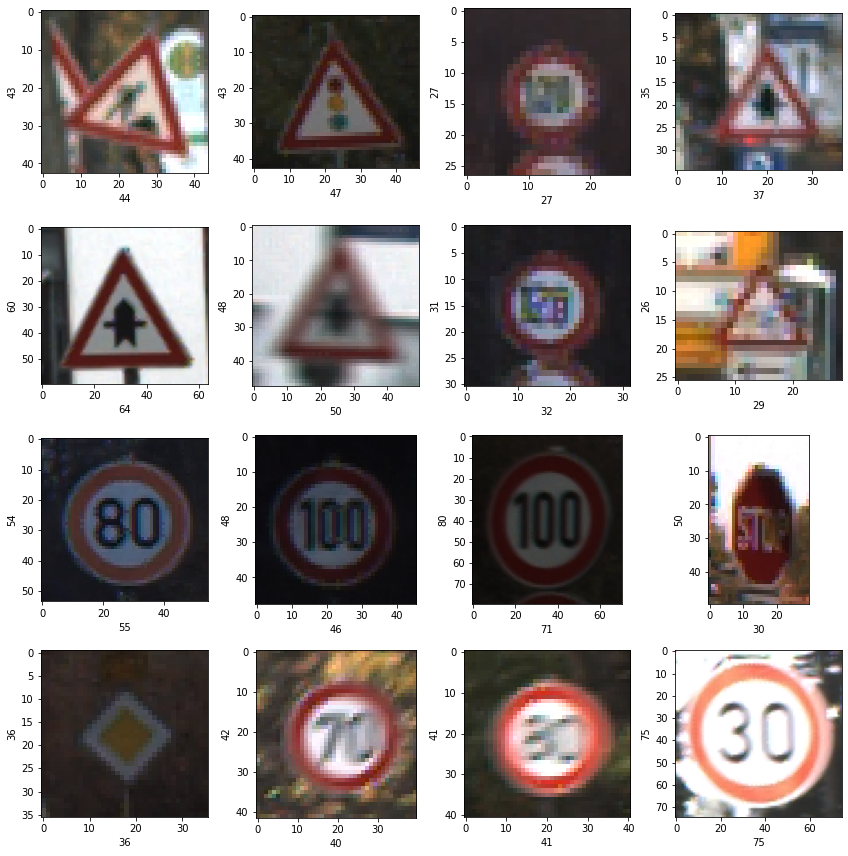

In [13]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "traffic_sign_dataset/Test"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image

In [15]:
ls traffic_sign_dataset/Train

0/   11/  14/  17/  2/   22/  25/  28/  30/  33/  36/  39/  41/  6/  9/
1/   12/  15/  18/  20/  23/  26/  29/  31/  34/  37/  4/   42/  7/
10/  13/  16/  19/  21/  24/  27/  3/   32/  35/  38/  40/  5/   8/


In [16]:
# As size of images are different we have to make them equal so we will take mean of dimensions
dim1 = []
dim2 = []

for i in range(0,43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = imread(labels + '/' + x)
        dim1.append(img.shape[0])
        dim2.append(img.shape[1])

In [17]:
#Printing mean dimension of images
print("Dimension 1 Mean : ",np.mean(dim1), " Dimension 2 Mean : ",np.mean(dim2))

Dimension 1 Mean :  50.328929582493814  Dimension 2 Mean :  50.83587951745773


In [18]:
# Now we will reshape the images to (50,50)
images = []
label_id = []

for i in range(43):
    labels = 'traffic_sign_dataset/Train' + '/{0}'.format(i)
    image_path = os.listdir(labels)
    for x in image_path:
        img = Image.open(labels + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)
        label_id.append(i)

In [19]:
#Converting images into numpy array
images = np.array(images)
#The pixel value of each image ranges between 0 and 255
#Dividing each image by 255 will scale the values between 0 and 1. This is also known as normalization.
images = images/255 

In [20]:
label_id = np.array(label_id)
label_id.shape

(39209,)

In [21]:
images.shape

(39209, 50, 50, 3)

In [24]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_id).value_counts()
label_counts.head()

2     2250
1     2220
13    2160
12    2100
38    2070
dtype: int64

In [25]:
#Splitting the data
x_train, x_val, y_train, y_val = train_test_split(images, label_id , test_size = 0.2, random_state = 42)

In [26]:
#keras has a built-in function for one-hot encoding.
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

In [27]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (3,3), input_shape = x_train.shape[1:], activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation = 'softmax'))

In [28]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 25, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 11, 11, 64)        0

In [29]:
model.fit(x_train, y_train, epochs = 10, batch_size = 128, validation_data = (x_val, y_val), verbose = 2)

Epoch 1/10
246/246 - 206s - loss: 2.4469 - accuracy: 0.3298 - val_loss: 1.2023 - val_accuracy: 0.6757 - 206s/epoch - 837ms/step
Epoch 2/10
246/246 - 204s - loss: 1.1352 - accuracy: 0.6456 - val_loss: 0.4767 - val_accuracy: 0.8990 - 204s/epoch - 827ms/step
Epoch 3/10
246/246 - 206s - loss: 0.7227 - accuracy: 0.7684 - val_loss: 0.2609 - val_accuracy: 0.9407 - 206s/epoch - 836ms/step
Epoch 4/10
246/246 - 206s - loss: 0.5432 - accuracy: 0.8253 - val_loss: 0.1651 - val_accuracy: 0.9700 - 206s/epoch - 836ms/step
Epoch 5/10
246/246 - 202s - loss: 0.4535 - accuracy: 0.8528 - val_loss: 0.1383 - val_accuracy: 0.9760 - 202s/epoch - 820ms/step
Epoch 6/10
246/246 - 195s - loss: 0.3898 - accuracy: 0.8751 - val_loss: 0.1134 - val_accuracy: 0.9799 - 195s/epoch - 791ms/step
Epoch 7/10
246/246 - 195s - loss: 0.3566 - accuracy: 0.8851 - val_loss: 0.0905 - val_accuracy: 0.9816 - 195s/epoch - 793ms/step
Epoch 8/10
246/246 - 195s - loss: 0.3269 - accuracy: 0.8936 - val_loss: 0.0774 - val_accuracy: 0.9847 - 

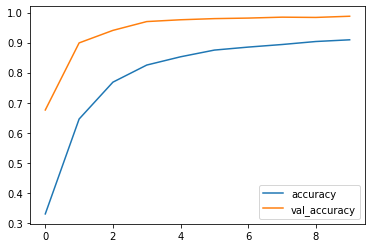

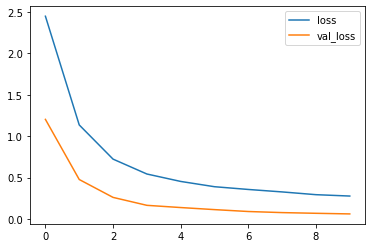

In [30]:
evaluation = pd.DataFrame(model.history.history)
evaluation[['accuracy', 'val_accuracy']].plot()
evaluation[['loss', 'val_loss']].plot()

In [31]:
test_path = 'traffic_sign_dataset/Test'
!rm traffic_sign_dataset/Test/GT-final_test.csv

In [32]:
#defining a function that will scale images
from PIL import Image

def scaling(test_images, test_path):
    images = []

    image_path = test_images
    
    for x in image_path:
        img = Image.open(test_path + '/' + x)
        img = img.resize((50,50))
        img = np.array(img)
        images.append(img)

    #Converting images into numpy array
    images = np.array(images)
    #The pixel value of each image ranges between 0 and 255
    #Dividing each image by 255 will scale the values between 0 and 1. This is also known as normalization.
    images = images/255

    return images

In [33]:
test_images = scaling(sorted(os.listdir(test_path)),test_path)

In [34]:
test = pd.read_csv('traffic_sign_dataset/Test.csv')
y_test = test['ClassId'].values
y_test

array([16,  1, 38, ...,  6,  7, 10])

In [36]:
predict_x=model.predict(test_images) 
y_pred=np.argmax(predict_x,axis=1)
y_pred

395/395 [==============================] - 19s 47ms/step


array([16,  1, 38, ..., 38,  7, 10])

In [37]:
# Storing all lables
all_lables = ['Speed limit (20km/h)','Speed limit (30km/h)','Speed limit (50km/h)','Speed limit (60km/h)',
              'Speed limit (70km/h)','Speed limit (80km/h)','End of speed limit (80km/h)','Speed limit (100km/h)',
              'Speed limit (120km/h)','No passing','No passing for vechiles over 3.5 metric tons',
              'Right-of-way at the next intersection','Priority road','Yield','Stop','No vechiles',
              'Vechiles over 3.5 metric tons prohibited','No entry','General caution','Dangerous curve to the left',
              'Dangerous curve to the right','Double curve','Bumpy road','Slippery road','Road narrows on the right',
              'Road work','Traffic signals','Pedestrians','Children crossing','Bicycles crossing','Beware of ice/snow',
              'Wild animals crossing','End of all speed and passing limits','Turn right ahead','Turn left ahead',
              'Ahead only','Go straight or right','Go straight or left','Keep right','Keep left','Roundabout mandatory',
              'End of no passing','End of no passing by vechiles over 3.5 metric']

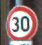

In [38]:
# Visualize test image
img = Image.open(test_path + '/00001.png')
img

In [39]:
# Original label
print("Original label : ",all_lables[y_test[1]])

Original label :  Speed limit (30km/h)


In [40]:
# Predicted label
print("Predicted label : ",all_lables[y_pred[1]])

Predicted label :  Speed limit (30km/h)


In [53]:
def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(2, 3, i + 1, xticks = [], yticks = [])
       
       
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{all_lables[labels[i]]}')
        plt.ylabel(f'{all_lables[preds[i]]}', color = col)
    plt.tight_layout()
    plt.show()

In [51]:
test_images[0:6].shape

(6, 50, 50, 3)

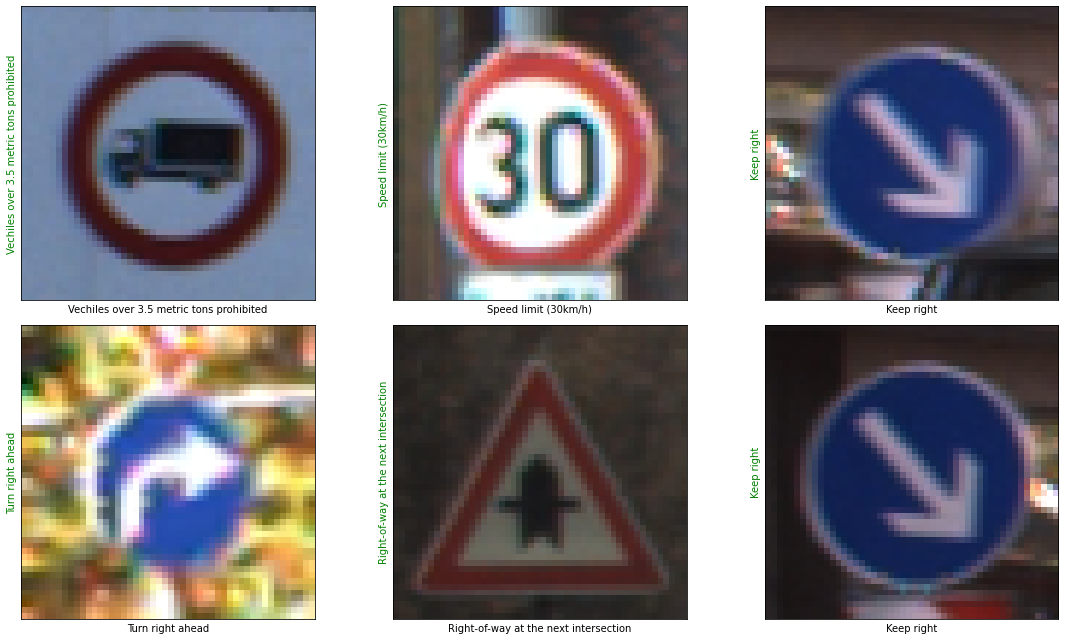

In [54]:
show_images(test_images[0:6], y_test[0:6], y_pred[0:6])